# LIMITED OBSERVATION PLOTS

## getting controlled csv for different configurations (note - change obs size)

I have to use a different rbc_env - rbc_env_limited_obs.py

In [2]:
import os
import numpy as np
import pandas as pd
from stable_baselines3 import PPO
from rbc_env_limited_obs import DedalusRBC_Env as LimitedObsEnv
import gymnasium as gym

# === Simulation Parameters (EDIT HERE) ===
Ra_value = 1e5
Nk = 128
discard_time = 100.0
action_duration = 0.5
n_actions = 256

ra_str = str(int(np.log10(Ra_value)))  # For folder naming
configs = [2, 3, 4, 5]               # Limited observation window configs
model_root_path = "/mnt/c/Kaushik/Python/rbc_project/most_used_files/nusselt_num_evolution/limited_observation"
output_root_path = model_root_path     # Save CSVs in same structure

# === Observation Windows by Config ===
obs_windows = {
    1: {"x_start": 0.0,  "x_end": 1.0,  "z_start": 0.0,  "z_end": 0.35},
    2: {"x_start": 0.0,  "x_end": 1.0,  "z_start": 0.65, "z_end": 1.0},
    3: {"x_start": 0.25, "x_end": 0.75, "z_start": 0.0,  "z_end": 1.0},
    4: {"x_start": 0.0,  "x_end": 1.0,  "z_start": 0.15, "z_end": 0.85},
    5: {"x_start": 0.25, "x_end": 0.75, "z_start": 0.15, "z_end": 0.85},
}

# === Main Loop ===
for config in configs:
    print(f"\n🤖 Starting RL-controlled simulation | Config {config} | Ra=1e{ra_str}, Nk={Nk}\n")

    # Get window limits
    window_params = obs_windows[config]

    # Create environment with limited observation
    env_controlled = LimitedObsEnv(**window_params)

    # Load trained PPO model
    model_path = os.path.join(model_root_path, f"models/Ra=1e{ra_str}/ppo_rbc_config{config}")
    model = PPO.load(model_path, env=env_controlled)

    # Reset env and simulate
    vec_env = model.get_env()
    obs = vec_env.reset()
    times, nus = [], []

    for i in range(n_actions):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, _, _ = vec_env.step(action)

        sim_time = env_controlled.unwrapped.solver.sim_time
        nu = env_controlled.unwrapped.fp.properties['Nu']['g'].flatten()[-1]

        times.append(sim_time)
        nus.append(nu)

        if i % 15 == 0 or i == n_actions - 1:
            print(f"[Config {config}] Step {i}/{n_actions}, t = {sim_time:.2f}s, Nu = {nu:.3f}")

    print(f"\n✅ Completed simulation for config {config}\n")

    # Save results
    df = pd.DataFrame({'Time': times, 'Nu': nus})
    save_path = os.path.join(output_root_path, f"Ra=1e{ra_str}/nu_controlled_phase_config_{config}.csv")
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    df.to_csv(save_path, index=False)

    print(f"📁 Saved results to: {save_path}\n")



🤖 Starting RL-controlled simulation | Config 2 | Ra=1e5, Nk=128

Initializing DedalusRBC_Env with x_start=0.0, x_end=1.0, z_start=0.65, z_end=1.0
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
2025-04-21 12:35:09,638 subsystems 0/1 INFO :: Building subproblem matrices 1/50 (~2%) Elapsed: 0s, Remaining: 3s, Rate: 1.4e+01/s
2025-04-21 12:35:09,771 subsystems 0/1 INFO :: Building subproblem matrices 5/50 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 2.5e+01/s
2025-04-21 12:35:09,942 subsystems 0/1 INFO :: Building subproblem matrices 10/50 (~20%) Elapsed: 0s, Remaining: 1s, Rate: 2.7e+01/s
2025-04-21 12:35:10,110 subsystems 0/1 INFO :: Building subproblem matrices 15/50 (~30%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s
2025-04-21 12:35:10,281 subsystems 0/1 INFO :: Building subproblem matrices 20/50 (~40%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s
2025-04-21 12:35:10,455 subsystems 0/1 INFO :: Building subproblem matrices 25/50 (~50%) Elapsed: 1s, Remaining: 1

## Nu evolution during the entire simulation for different limited observation configurations

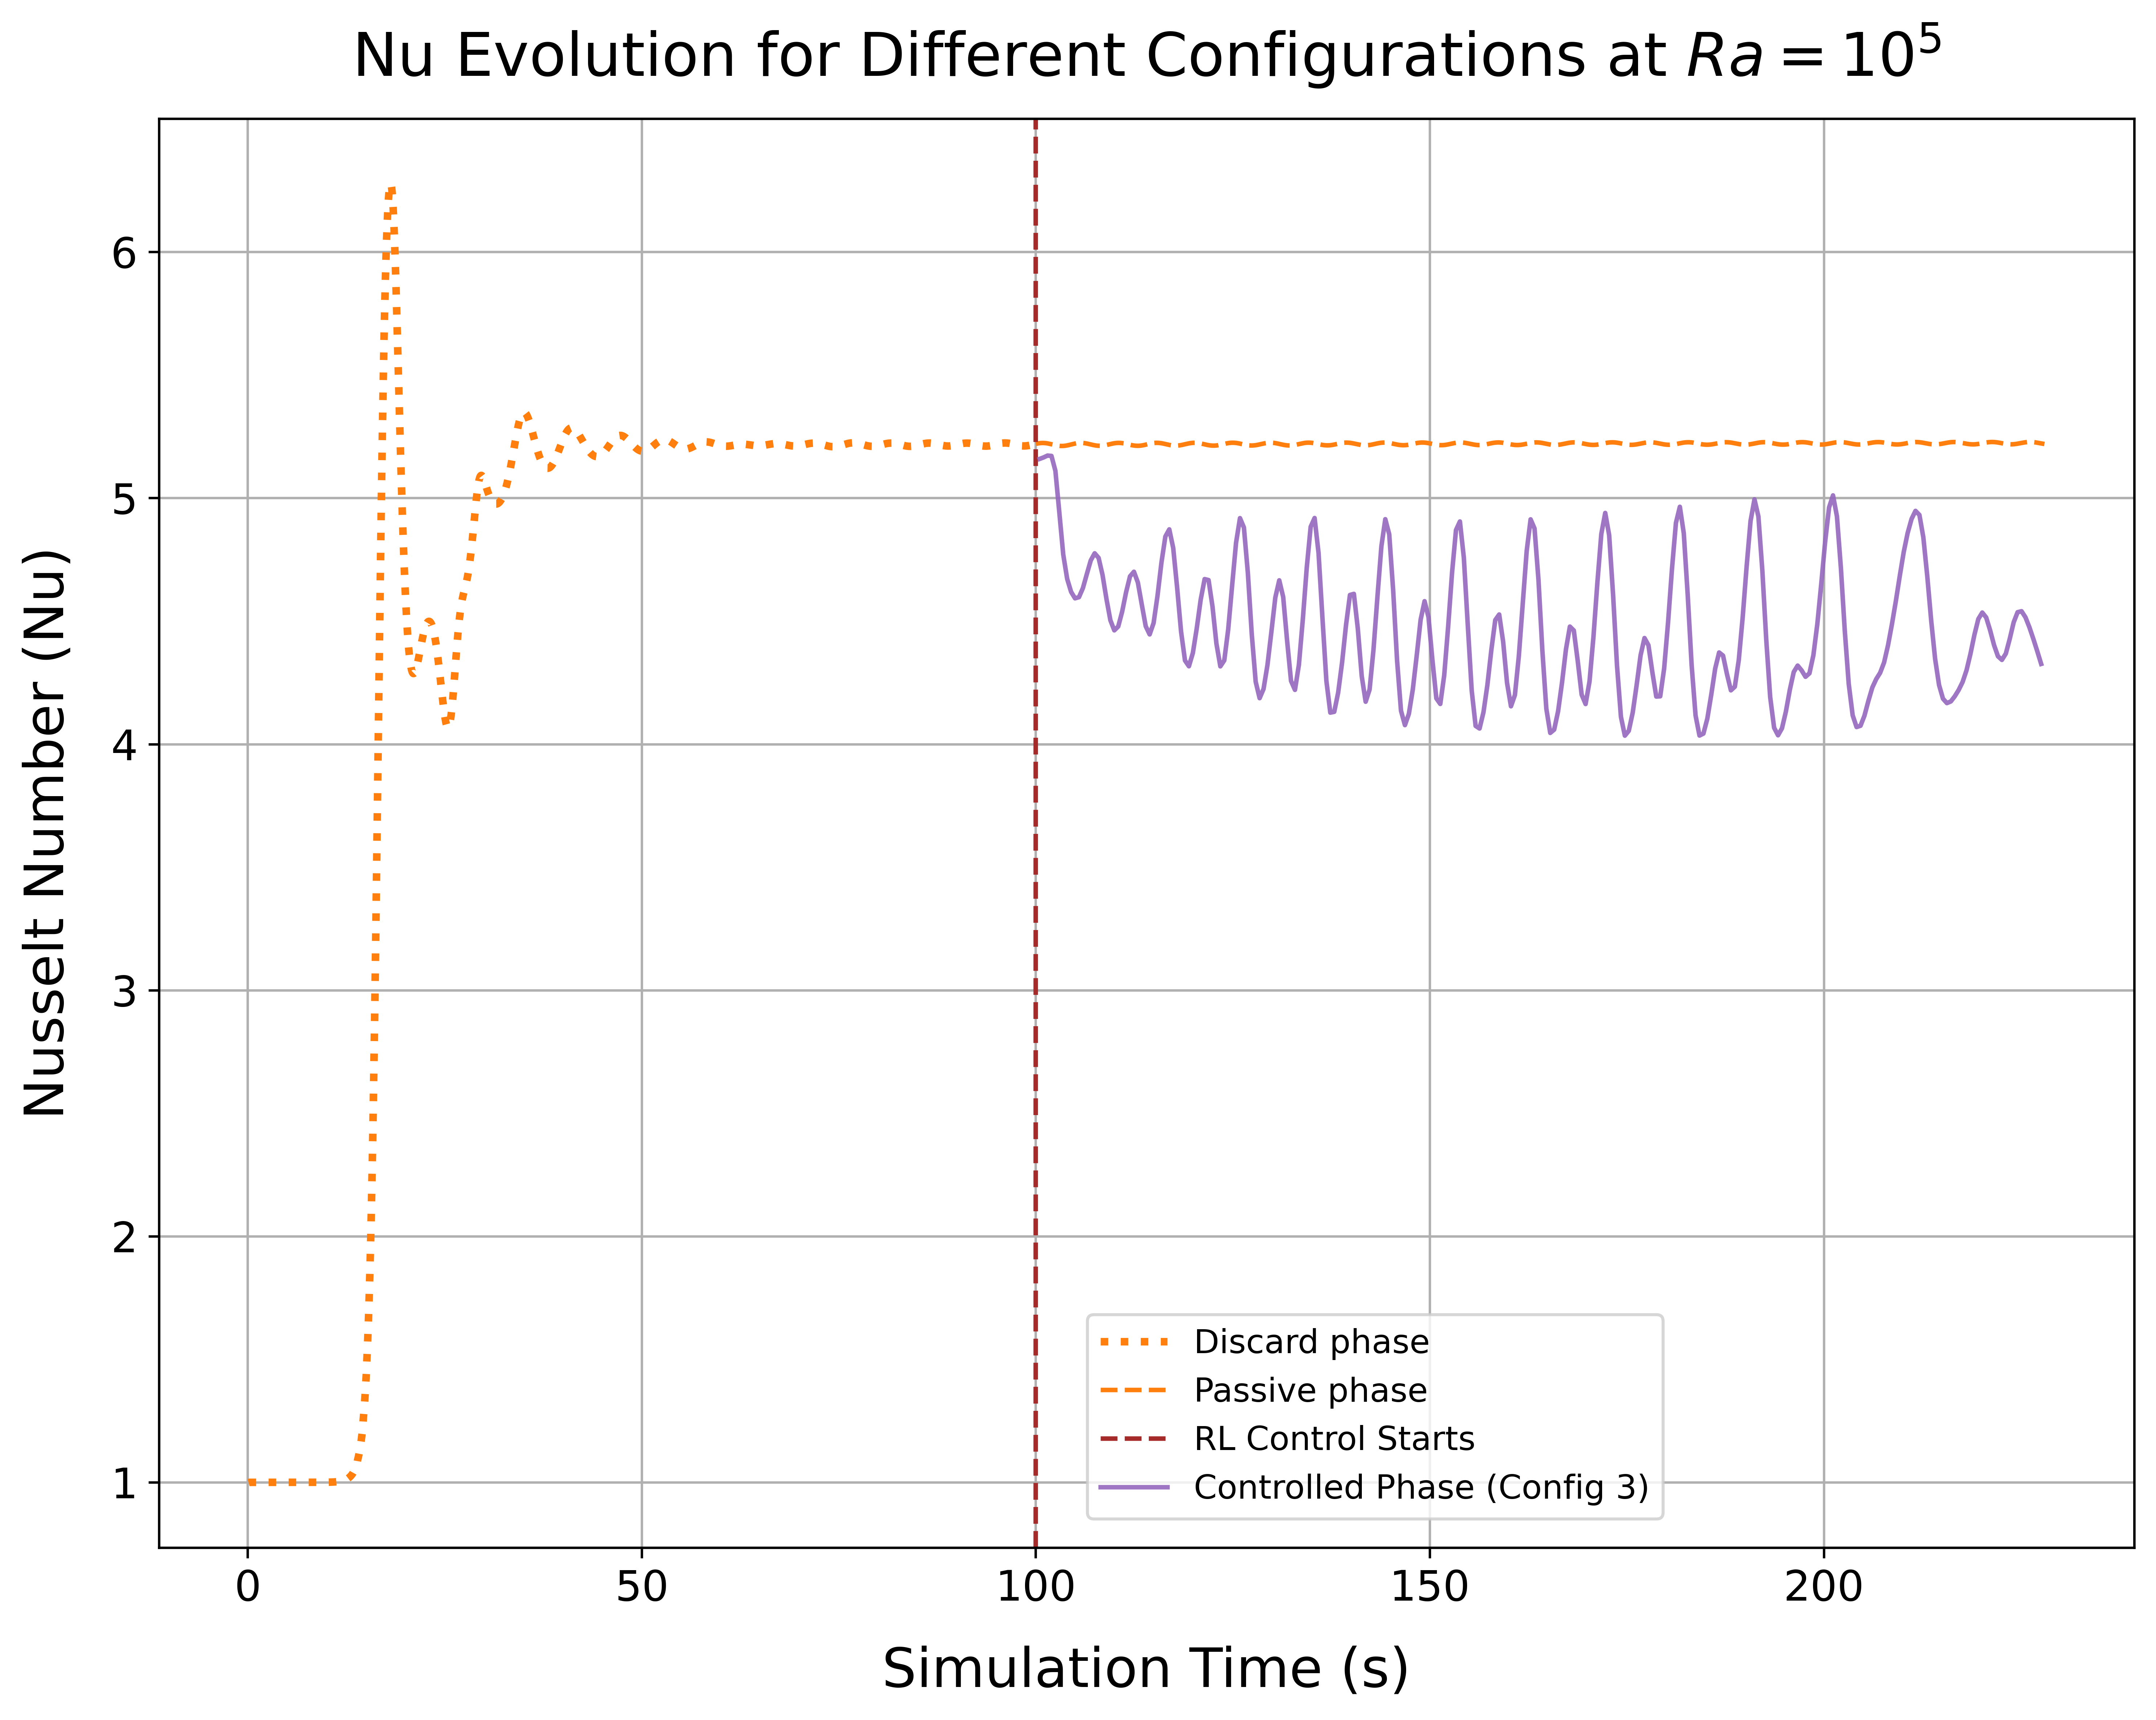

Plot saved at path /mnt/c/Kaushik/Python/rbc_project/most_used_files/nusselt_num_evolution/limited_observation/Nusselt_all_configs_ra=5.png


In [20]:

import matplotlib.pyplot as plt
import os

ra="5"

path1 = f"/mnt/c/Kaushik/Python/rbc_project/most_used_files/nusselt_num_evolution/limited_observation/Ra=1e{ra}"


df_discard = pd.read_csv(os.path.join(path1, "nu_discard_phase_common.csv"))
df_passive = pd.read_csv(os.path.join(path1, "nu_passive_phase_common.csv"))

plt.figure(figsize=(10, 8), dpi=600)

plt.plot(df_discard["Time"], df_discard["Nu"], label="Discard phase", linestyle=':', color='tab:orange',linewidth=2.5)
plt.plot(df_passive["Time"], df_passive["Nu"], label="Passive phase", linestyle='--', color='tab:orange')

discard_time = 100
plt.axvline(x=discard_time, color='brown', linestyle='--', label='RL Control Starts')

configs = [3]

config_colors = {
    1: 'tab:red',
    2: 'blue',
    3: 'tab:purple',
    4: 'tab:green',
    5: 'tab:pink'
}

for config in configs:

    df_controlled = pd.read_csv(os.path.join(path1, f"nu_controlled_phase_config_{config}.csv"))
    color = config_colors.get(config, None)  # fallback to default if not specified
    plt.plot(df_controlled["Time"], df_controlled["Nu"], label=f"Controlled Phase (Config {config})", color=color, alpha=0.9)



plt.xlabel("Simulation Time (s)", fontsize=18, labelpad=12)
plt.ylabel("Nusselt Number (Nu)", fontsize=18, labelpad=12)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title(f"Nu Evolution for Different Configurations at $Ra=10^{ra}$", fontsize=20, pad=14)
plt.legend(loc=(0.47,0.02), fontsize=11)
plt.grid(True)
plt.tight_layout()


plot_save_path=f"/mnt/c/Kaushik/Python/rbc_project/most_used_files/nusselt_num_evolution/limited_observation/Nusselt_all_configs_ra={ra}.png"
plt.savefig(plot_save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Plot saved at path {plot_save_path}")

## Nu plot for just the controlled part for lim obs configs

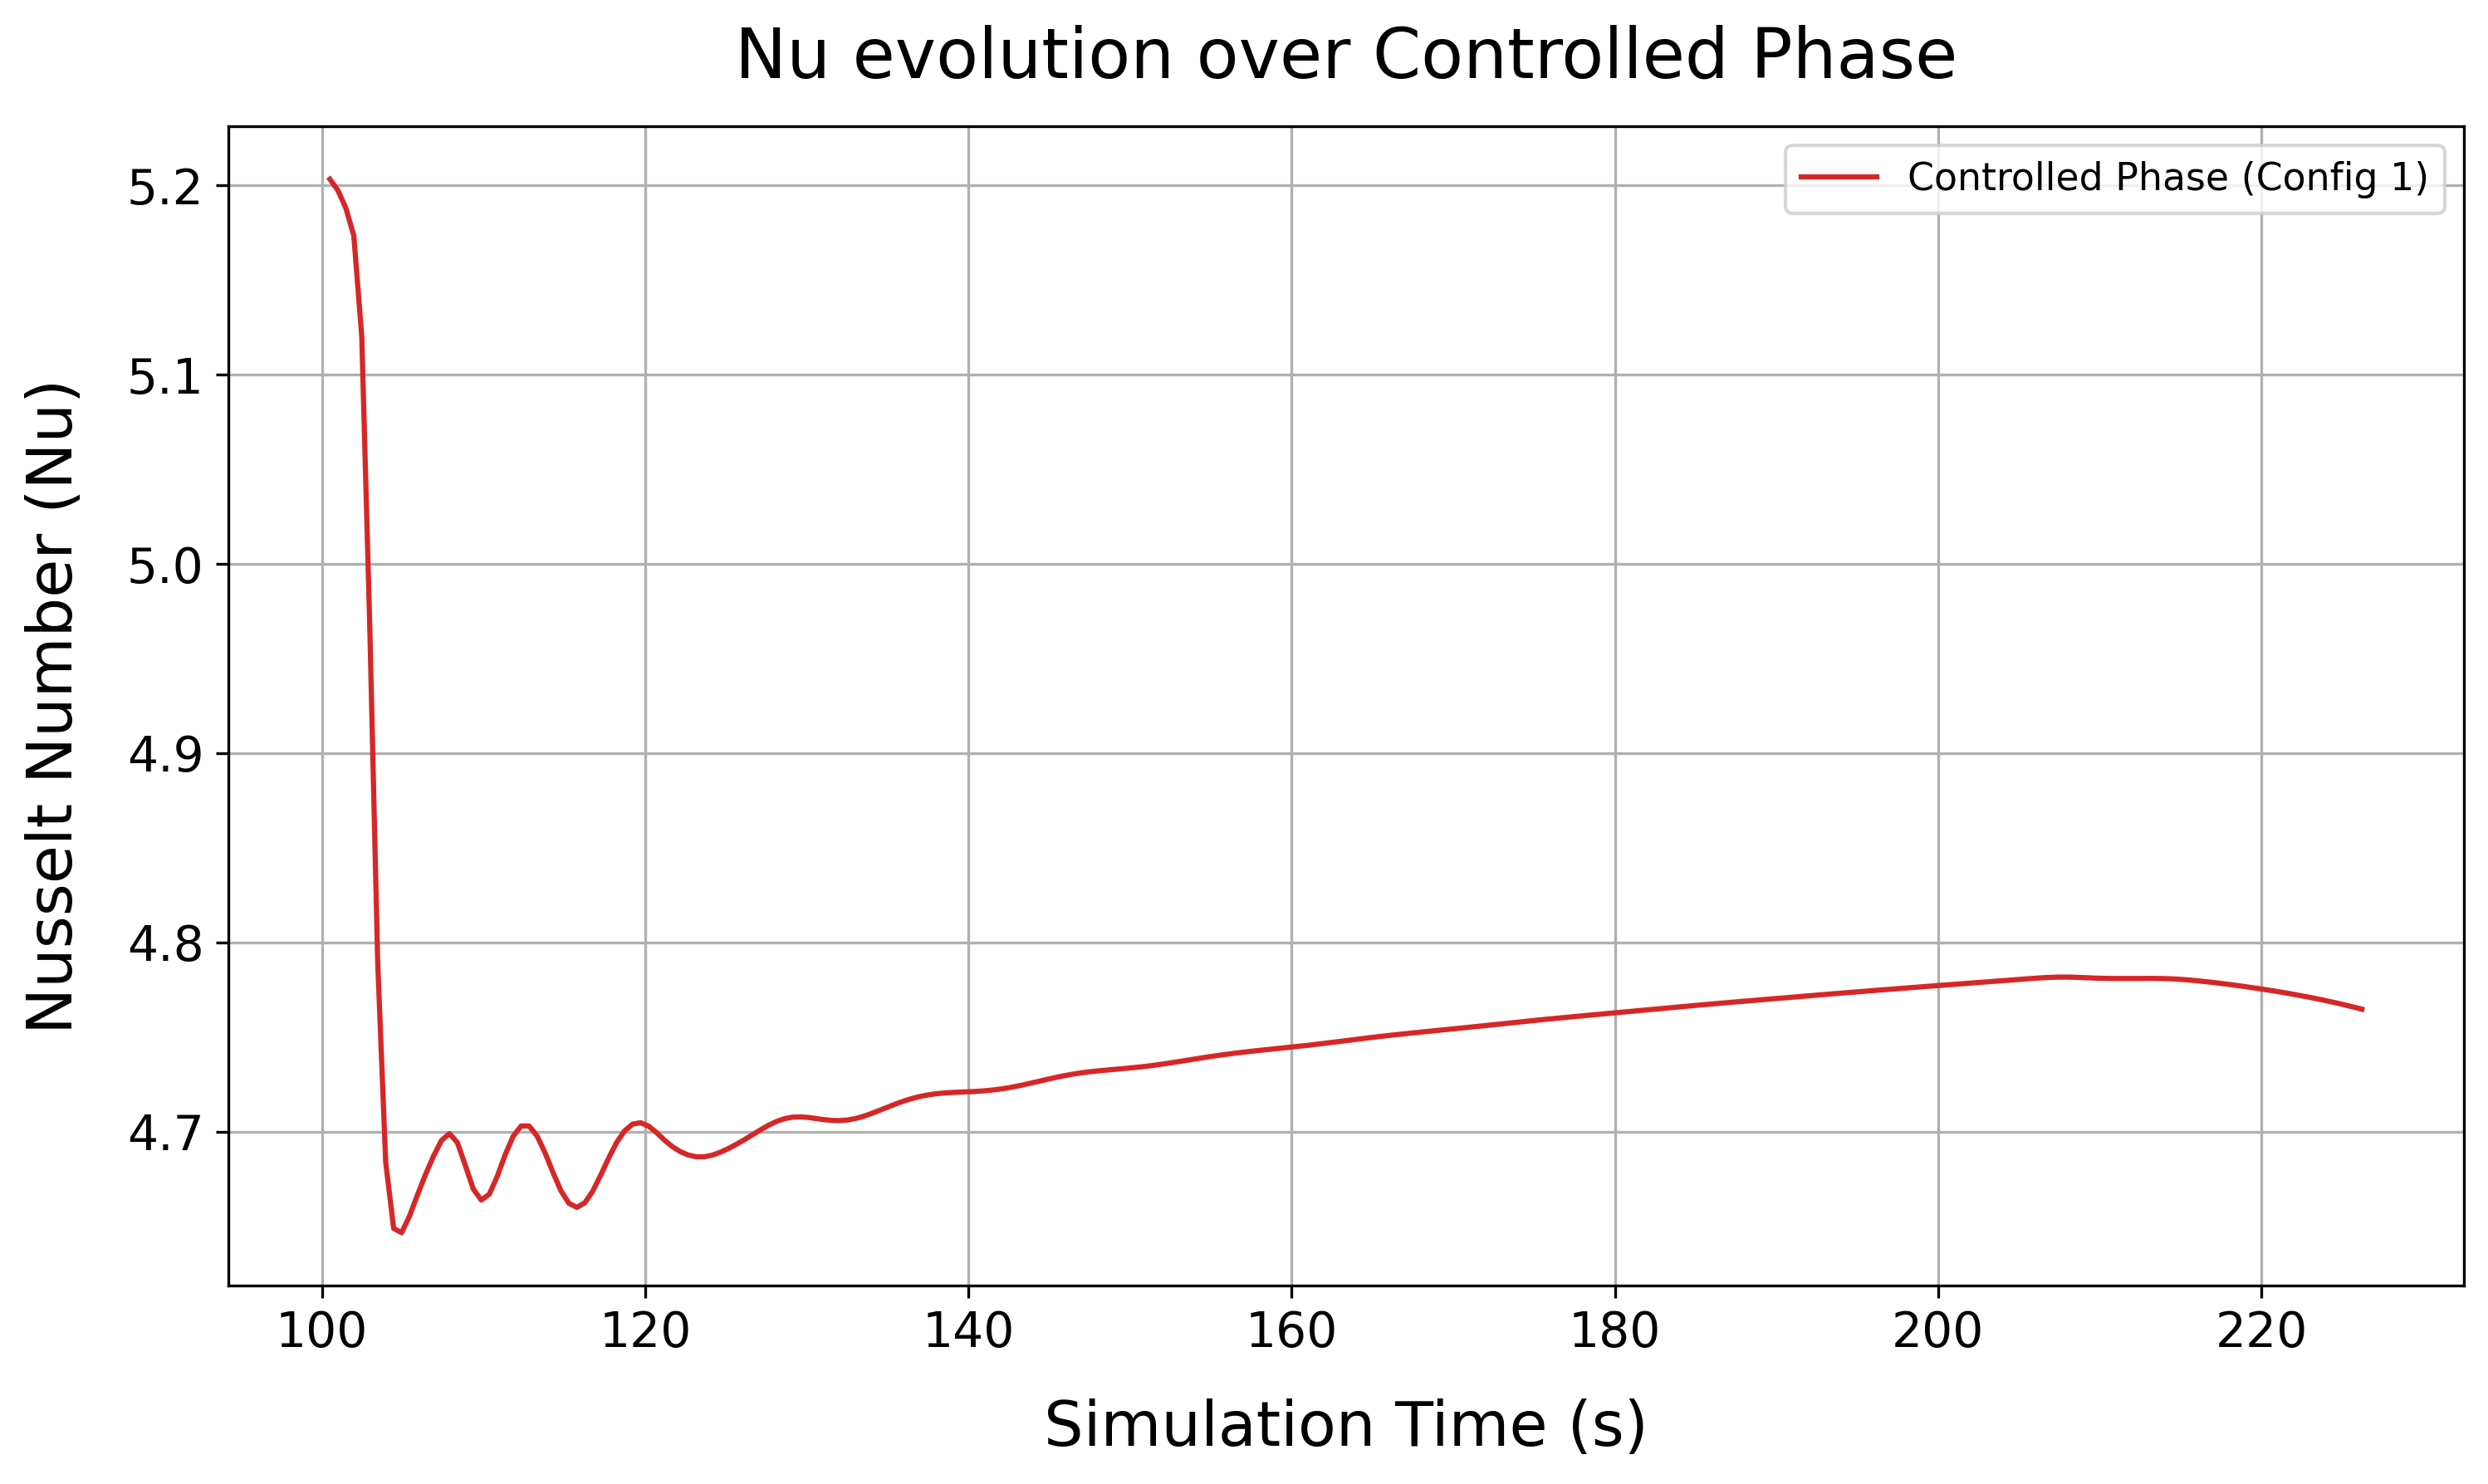

In [8]:
import pandas as pd
import os
import matplotlib.pyplot as plt

ra="5"

path1 = f"/mnt/c/Kaushik/Python/rbc_project/most_used_files/nusselt_num_evolution/limited_observation/Ra=1e{ra}"


df_discard = pd.read_csv(os.path.join(path1, "nu_discard_phase_common.csv"))
df_passive = pd.read_csv(os.path.join(path1, "nu_passive_phase_common.csv"))

plt.figure(figsize=(10, 6), dpi=300)


configs = [1]
#configs = [1,2,4]

# Define fixed colors for each config
config_colors = {
    1: 'tab:red',
    2: 'blue',
    3: 'tab:purple',
    4: 'tab:green',
    5: 'tab:pink'
}

for config in configs:

    df_controlled = pd.read_csv(os.path.join(path1, f"nu_controlled_phase_config_{config}.csv"))
    color = config_colors.get(config, None)  # fallback to default if not specified
    plt.plot(df_controlled["Time"], df_controlled["Nu"], label=f"Controlled Phase (Config {config})", color=color)


plt.xlabel("Simulation Time (s)", fontsize=18, labelpad=12)
plt.ylabel("Nusselt Number (Nu)", fontsize=18, labelpad=12)
plt.title(f"Nu evolution over Controlled Phase", fontsize=20, pad=14)
plt.legend(fontsize=11)
plt.grid(True)
plt.tight_layout()
plt.xticks(size=14)
plt.yticks(size=14)

#plt.savefig(os.path.join(path1, "nu_evolution_different_configs_controlled_part.png"), dpi=300, bbox_inches='tight')
plt.show()

## All phases for just one particular limited obs config

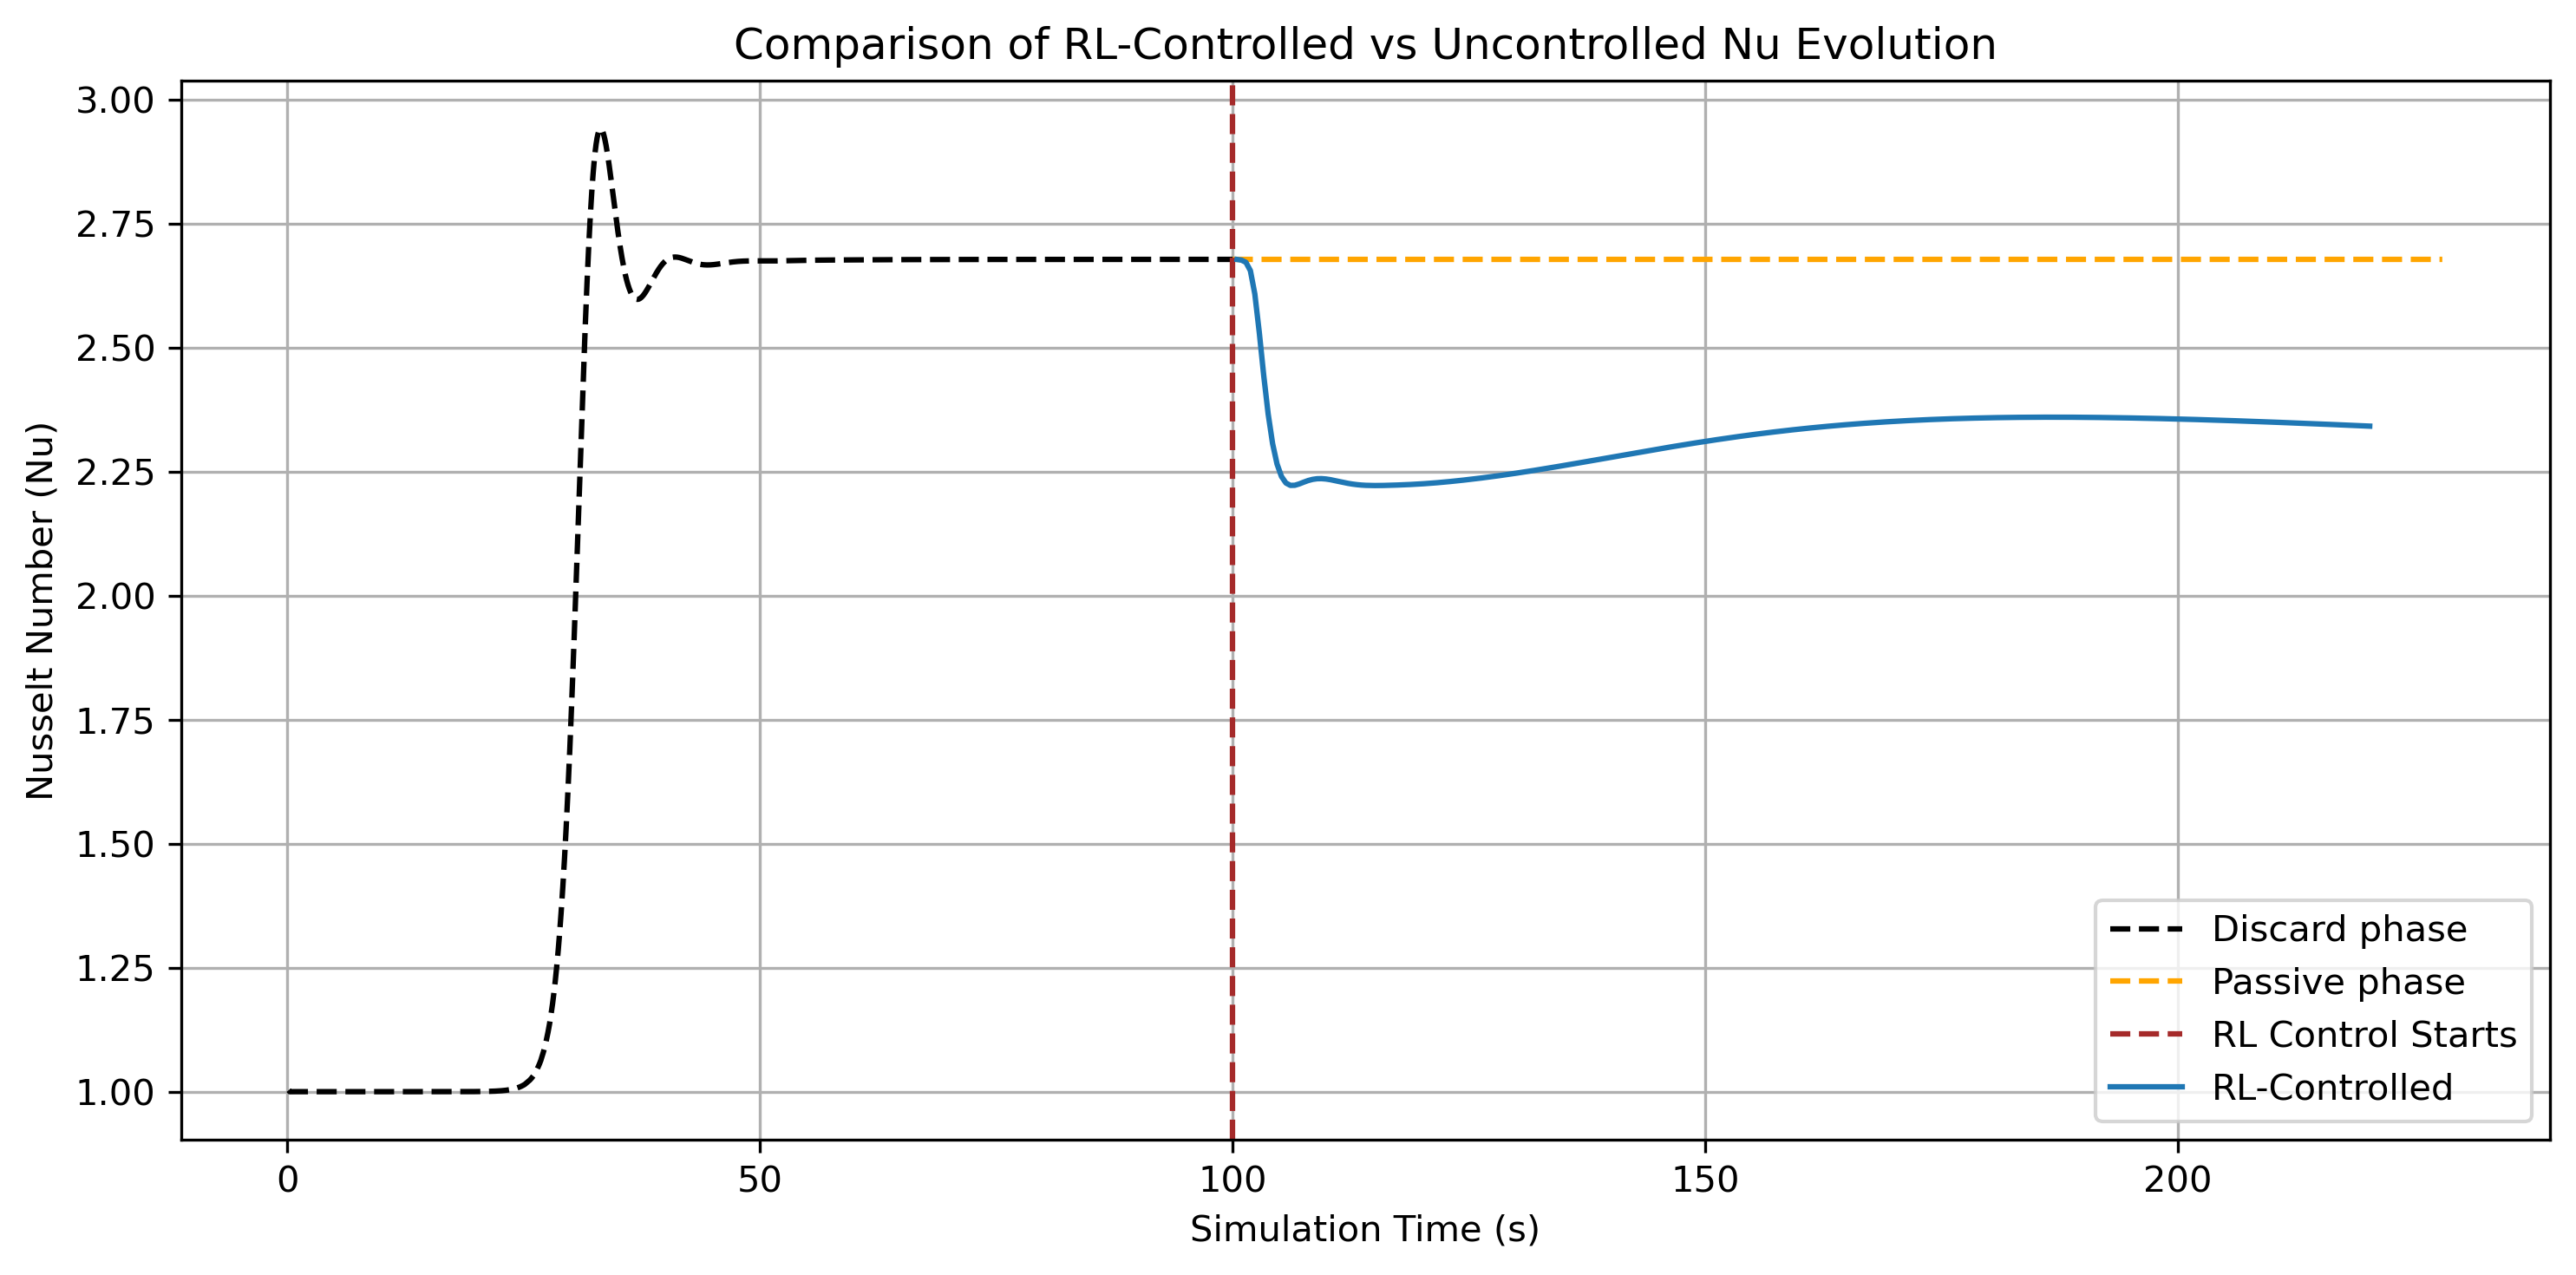

Plot saved at path /mnt/c/Kaushik/Python/rbc_project/most_used_files/nusselt_num_evolution/limited_observation/all phases - for config 2.png


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

path1 = f"/mnt/c/Kaushik/Python/rbc_project/most_used_files/nusselt_num_evolution/limited_observation/"

df_discard = pd.read_csv(os.path.join(path1, "nu_discard_phase_common.csv"))
df_passive = pd.read_csv(os.path.join(path1, "nu_passive_phase_common.csv"))

plt.figure(figsize=(10, 5), dpi=300)

plt.plot(df_discard["Time"], df_discard["Nu"], label="Discard phase", linestyle='--', color='black')
plt.plot(df_passive["Time"], df_passive["Nu"], label="Passive phase", linestyle='--', color='orange')

discard_time = 100
plt.axvline(x=discard_time, color='brown', linestyle='--', label='RL Control Starts')

config=2

df_controlled = pd.read_csv(os.path.join(path1, f"nu_controlled_phase_config_{config}.csv"))
plt.plot(df_controlled["Time"], df_controlled["Nu"], label=f"RL-Controlled")



plt.xlabel("Simulation Time (s)")
plt.ylabel("Nusselt Number (Nu)")
plt.title(f"Comparison of RL-Controlled vs Uncontrolled Nu Evolution")
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()

plot_name = os.path.join(path1, f"all phases - for config {config}.png")
plt.savefig(plot_name, dpi=300, bbox_inches='tight')
plt.show()
print(f"Plot saved at path {plot_name}")

## Nusselt num evolution for different Ra for the best limited config


Percentage Drop in Nu (Discard → Controlled) for Limited Observation Config 2:
Ra=1e4:
  Discard Converged Nu  = 2.6785
  Final Controlled Nu   = 2.2917
  ↓ Percent Reduction   = 14.44%

Ra=1e5:
  Discard Converged Nu  = 5.2168
  Final Controlled Nu   = 4.3277
  ↓ Percent Reduction   = 17.04%



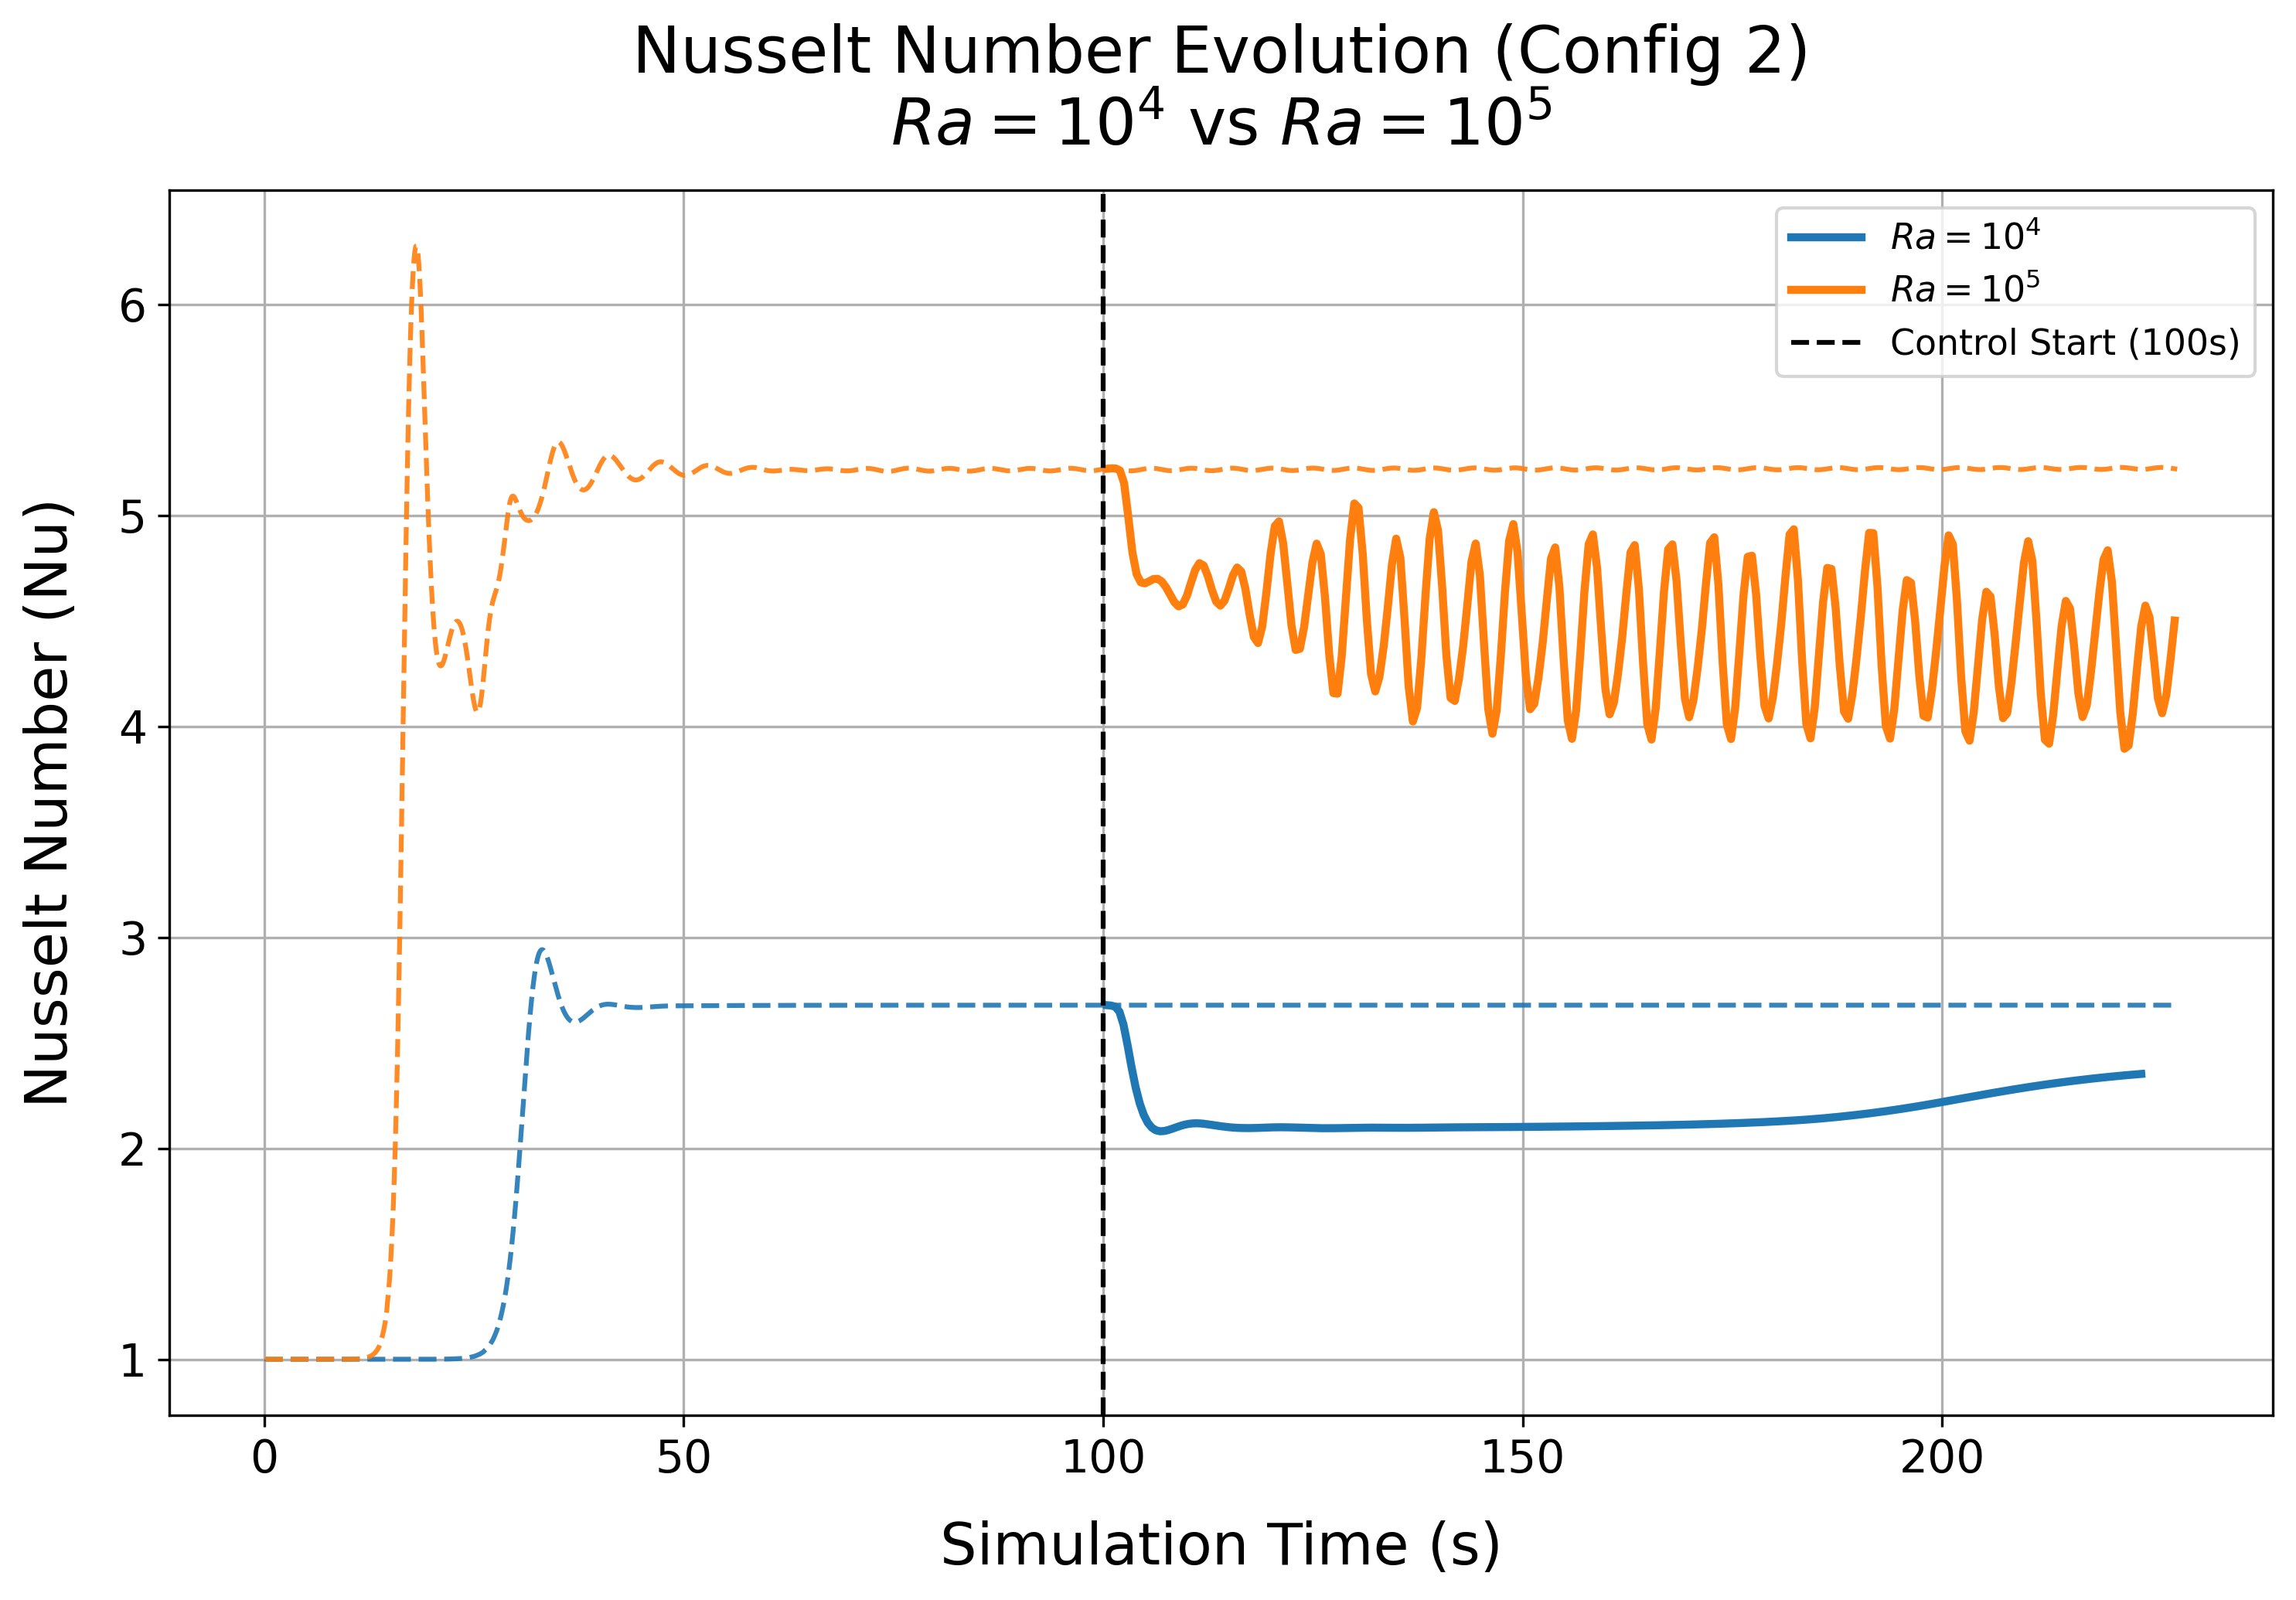

Plot saved at: /mnt/c/Kaushik/Python/rbc_project/most_used_files/nusselt_num_evolution/limited_observation/nu_full_comparison_config2_ra4_vs_ra5.png


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

base_path = "/mnt/c/Kaushik/Python/rbc_project/most_used_files/nusselt_num_evolution/limited_observation"
config=2
rayleigh_numbers = [4, 5]

# Customize colors for consistency
colors = {
    4: 'tab:blue',
    5: 'tab:orange'
}

plt.figure(figsize=(10, 7), dpi=300)

nu_drop_results = {}

for ra in rayleigh_numbers:
    path = os.path.join(base_path, f"Ra=1e{ra}")
    
    # Load discard and passive phase data
    df_discard = pd.read_csv(os.path.join(path, "nu_discard_phase_common.csv"))

    # Estimate converged discard Nu: average over the last 5% of discard time
    discard_n = len(df_discard)
    discard_nu_converged = df_discard["Nu"].iloc[-discard_n//5:].mean()
    
    df_passive = pd.read_csv(os.path.join(path, "nu_passive_phase_common.csv"))

    # Plot discard and passive curves
    plt.plot(df_discard["Time"], df_discard["Nu"], linestyle='--', color=colors[ra], alpha=0.9)
    plt.plot(df_passive["Time"], df_passive["Nu"], linestyle='--', color=colors[ra], alpha=0.9)

    # Load controlled data for each Ra for config
    df_controlled = pd.read_csv(os.path.join(path, f"nu_controlled_phase_config_{config}.csv"))

    plt.plot(df_controlled["Time"], df_controlled["Nu"], label=f"$Ra=10^{ra}$", color=colors[ra], linewidth=2.5)


    # Estimate final Nu value: average over the last 5% of the controlled time
    final_nu = df_controlled["Nu"][-len(df_controlled)//5:].mean()

    # Compute % drop
    percent_drop = ((discard_nu_converged - final_nu) / discard_nu_converged) * 100
    nu_drop_results[ra] = {
        "Discard Converged Nu": discard_nu_converged,
        "Final Controlled Nu": final_nu,
        "Percent Drop": percent_drop
    }


# Print results nicely
print(f"\nPercentage Drop in Nu (Discard → Controlled) for Limited Observation Config {config}:")
for ra, stats in nu_drop_results.items():
    print(f"Ra=1e{ra}:")
    print(f"  Discard Converged Nu  = {stats['Discard Converged Nu']:.4f}")
    print(f"  Final Controlled Nu   = {stats['Final Controlled Nu']:.4f}")
    print(f"  ↓ Percent Reduction   = {stats['Percent Drop']:.2f}%\n")

# Add control start marker (same for both)
plt.axvline(x=100, color='black', linestyle='--', linewidth=1.5, label='Control Start (100s)')

# Final plot formatting
plt.title(f"Nusselt Number Evolution (Config {config})\n$Ra = 10^4$ vs $Ra = 10^5$", fontsize=20, pad=14)
plt.xlabel("Simulation Time (s)", fontsize=18, labelpad=12)
plt.ylabel("Nusselt Number (Nu)", fontsize=18, labelpad=12)
plt.xticks(size=14)
plt.yticks(size=14)


plt.legend(fontsize=11, loc='upper right')
plt.grid(True)
plt.tight_layout()

# Save
save_path = os.path.join(base_path, f"nu_full_comparison_config{config}_ra4_vs_ra5.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Plot saved at: {save_path}")


## Percentage reduction with Std at different Ra for different limited configs

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

base_path = "/mnt/c/Kaushik/Python/rbc_project/most_used_files/nusselt_num_evolution/limited_observation"

configs = [1, 2, 3, 4, 5]
rayleigh_numbers = [4, 5]  # Ra = 1e4 and 1e5

# Store results: key = seed, value = { (Ra, metric): value }
results = {}

for config in configs:
    seed_data = {}
    for ra in rayleigh_numbers:
        path = os.path.join(base_path, f"Ra=1e{ra}")

        # Load discard phase
        df_discard = pd.read_csv(os.path.join(path, "nu_discard_phase_common.csv"))
        discard_tail = df_discard["Nu"].iloc[-len(df_discard)//5:]
        discard_nu_converged = discard_tail.mean()

        # Load controlled phase
        df_controlled = pd.read_csv(os.path.join(path, f"nu_controlled_phase_config_{config}.csv"))
        controlled_tail = df_controlled["Nu"].iloc[-len(df_controlled)//5:]

        final_nu_mean = controlled_tail.mean()
        final_nu_std = controlled_tail.std()

        formatted_final_nu = f"{final_nu_mean:.4f} ± {final_nu_std:.4f}"

        percent_drop = ((discard_nu_converged - final_nu_mean) / discard_nu_converged) * 100

        # Store for current seed
        seed_data[(f"Ra=1e{ra}", "Final Nu (±SD)")] = formatted_final_nu
        seed_data[(f"Ra=1e{ra}", "% Drop")] = round(percent_drop, 2)

    results[f"Config {config}"] = seed_data

# Create MultiIndex DataFrame
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = pd.MultiIndex.from_tuples(df.columns)

# Define the file path
df_name = "nu_drop_results_different_configs.xlsx"
save_path = os.path.join(base_path, df_name)

# Save to Excel
df.to_excel(save_path)

print(f"Saved results to {df_name} at {base_path}")

# Display the resulting DataFrame
print(df)


Saved results to nu_drop_results_different_configs.xlsx at /mnt/c/Kaushik/Python/rbc_project/most_used_files/nusselt_num_evolution/limited_observation
                   Ra=1e4                  Ra=1e5       
           Final Nu (±SD) % Drop   Final Nu (±SD) % Drop
Config 1  2.2080 ± 0.0107  17.57  4.7775 ± 0.0047   8.42
Config 2  2.2917 ± 0.0425  14.44  4.3277 ± 0.2738  17.04
Config 3  1.9851 ± 0.0288  25.89  4.4269 ± 0.2260  15.14
Config 4  1.7793 ± 0.0706  33.57  4.6063 ± 0.1019  11.70
Config 5  2.5381 ± 0.0033   5.24  4.6712 ± 0.3006  10.46


## comparing best performing lim obs with average seed of full observation

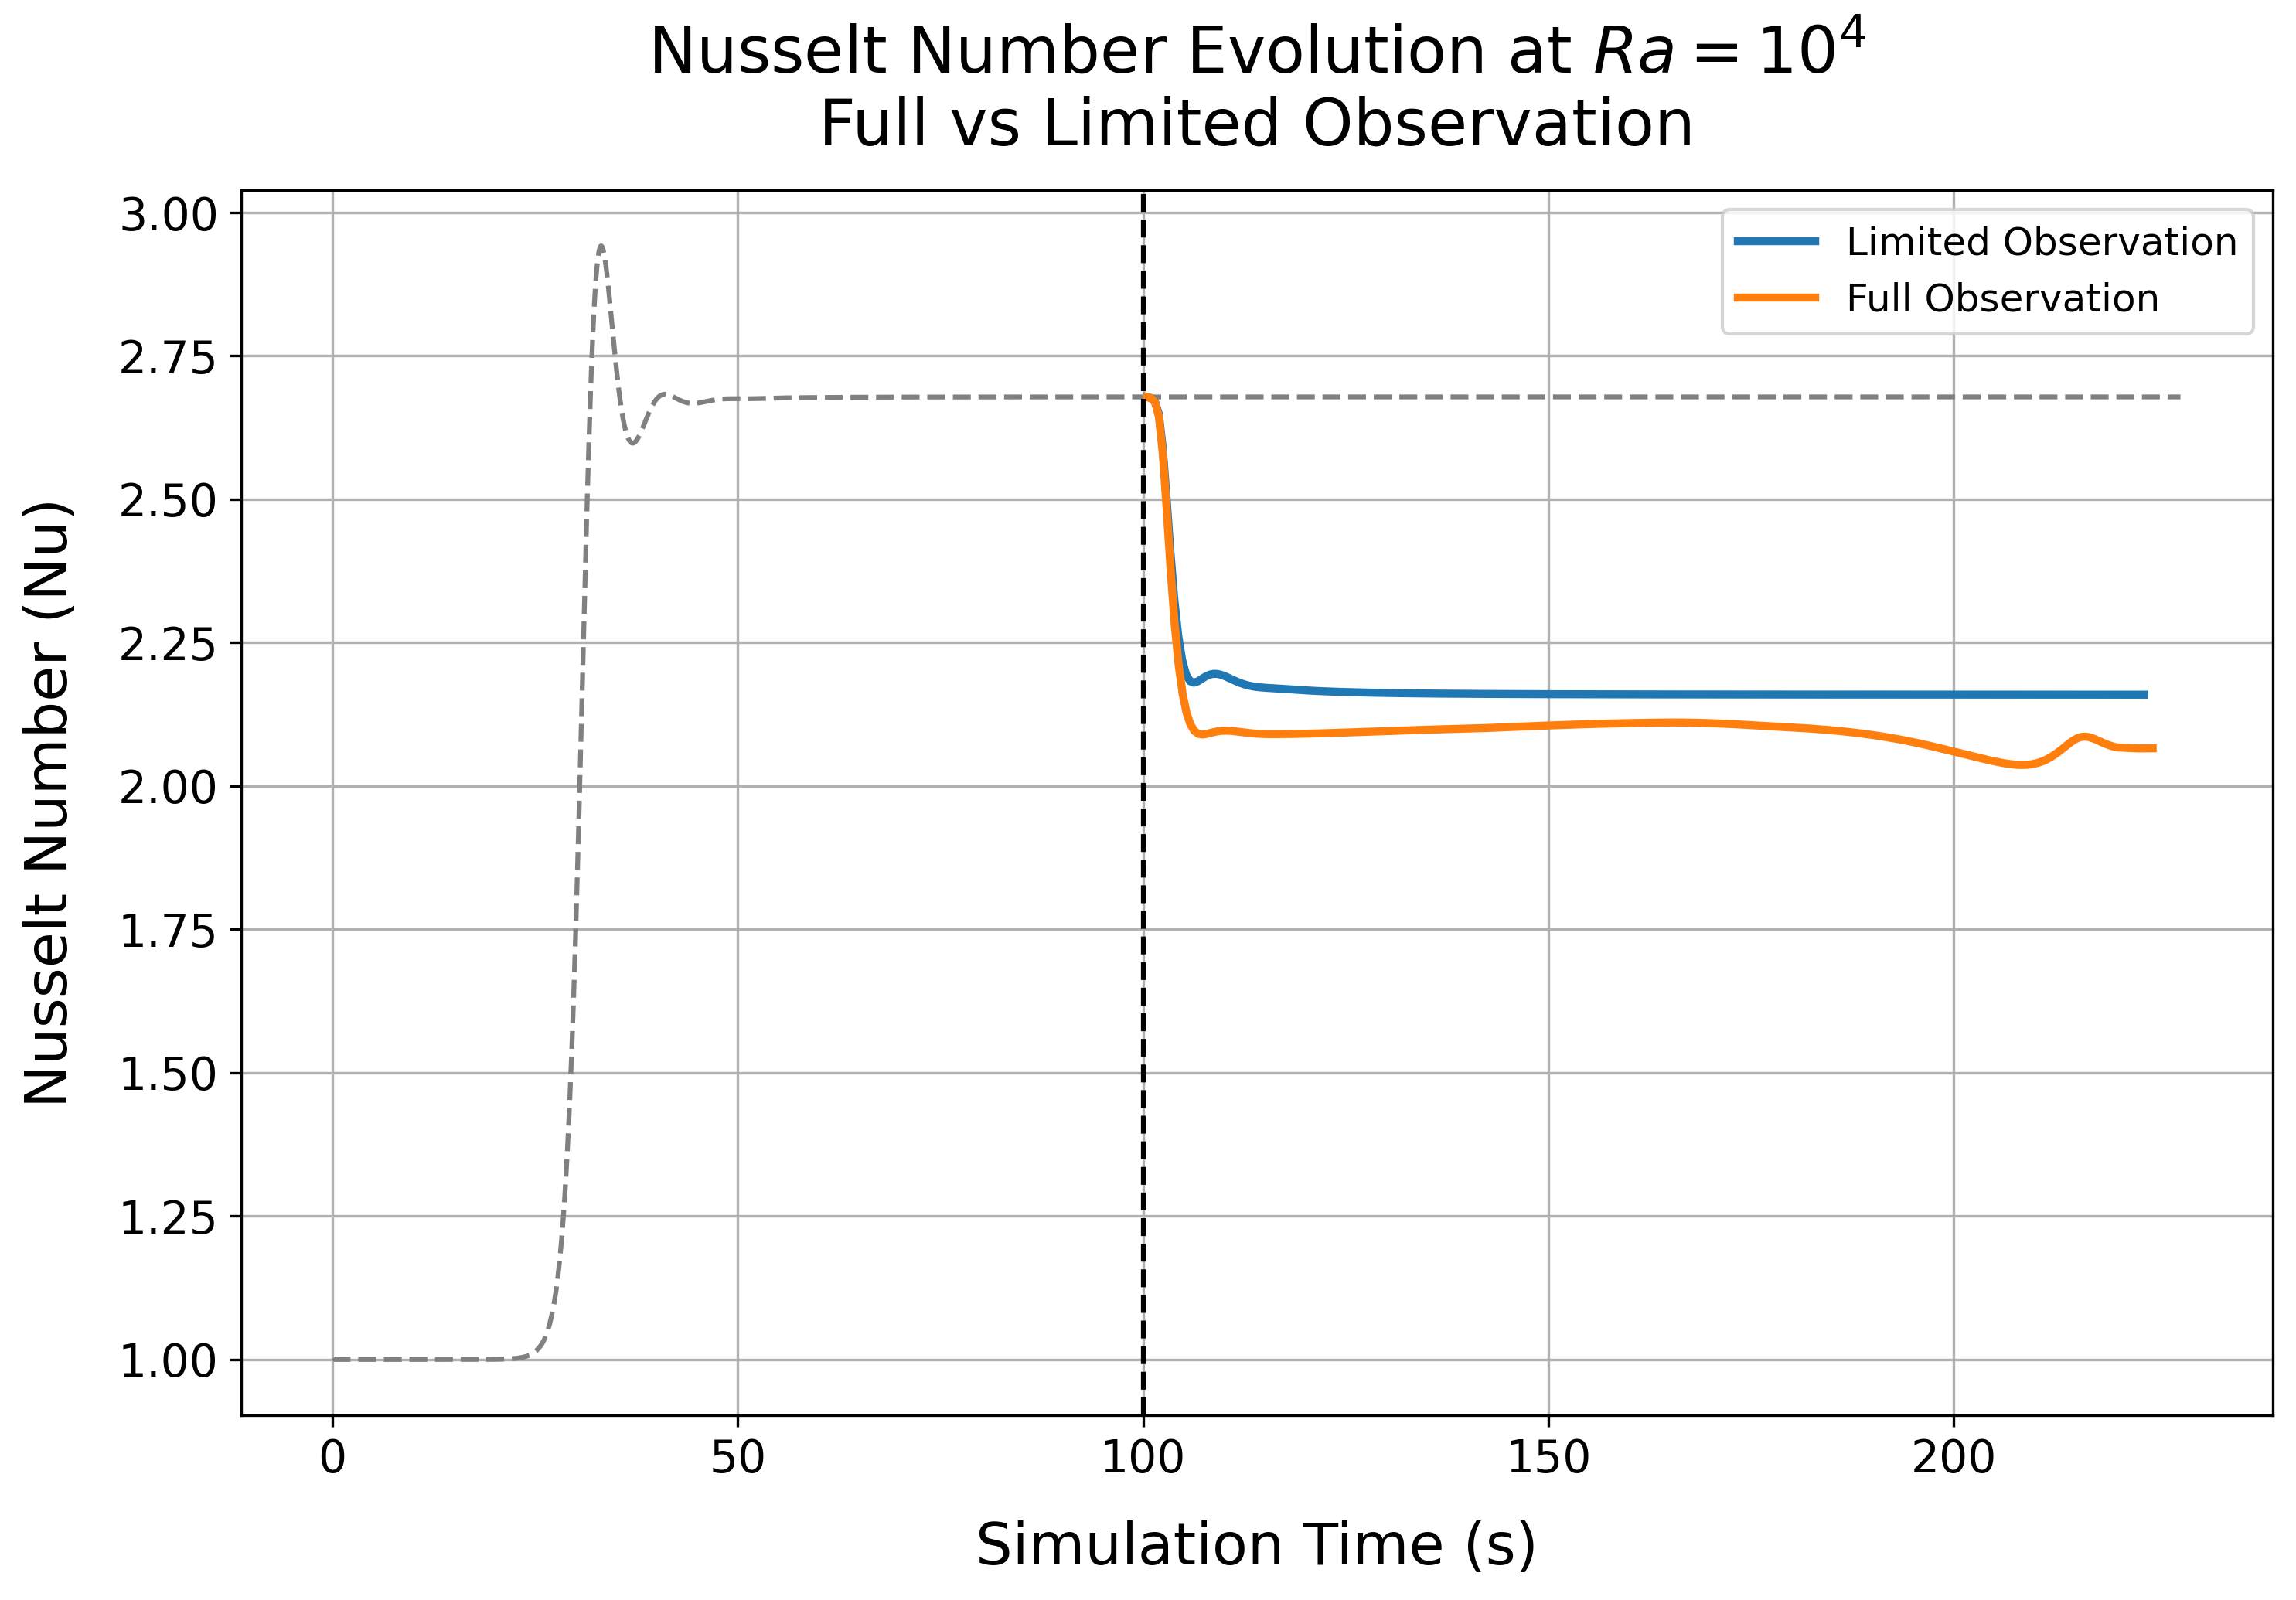

Plot for Ra=1e4 saved at: /mnt/c/Kaushik/Python/rbc_project/most_used_files/nusselt_num_evolution/nu_comparison_full_vs_lim_obs_ra4.png


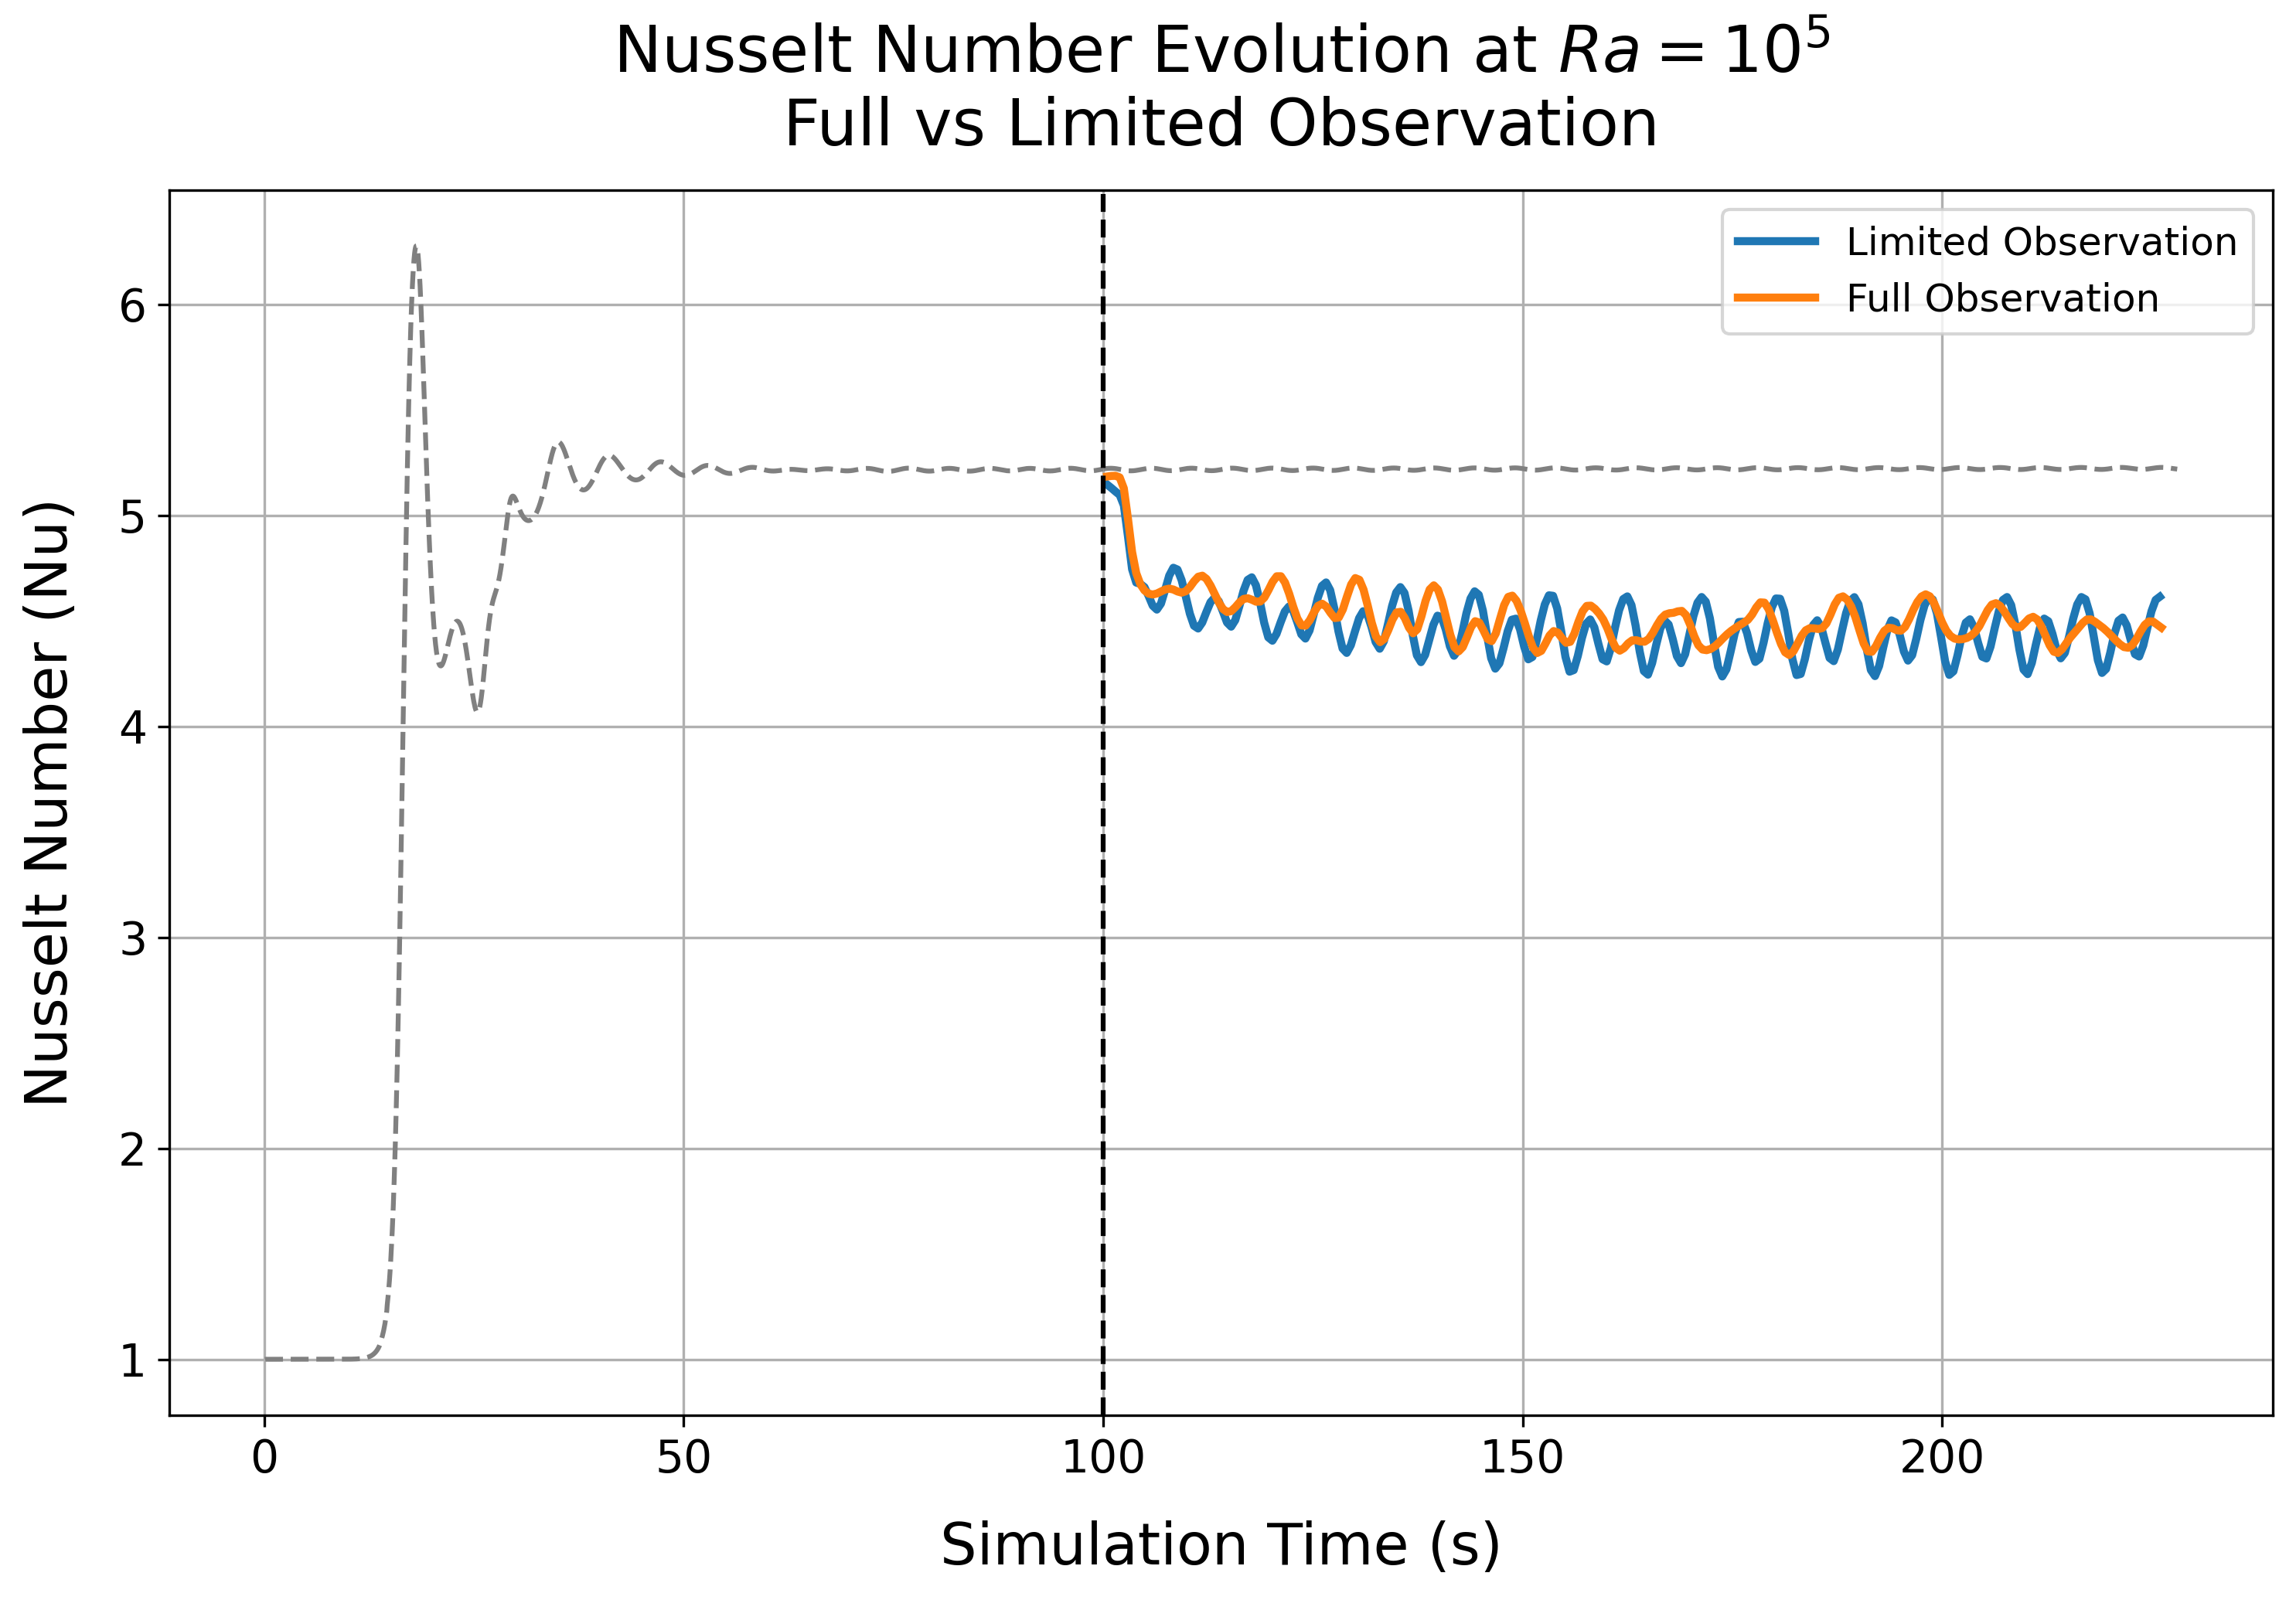

Plot for Ra=1e5 saved at: /mnt/c/Kaushik/Python/rbc_project/most_used_files/nusselt_num_evolution/nu_comparison_full_vs_lim_obs_ra5.png


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# Paths
base_path_config4 = "/mnt/c/Kaushik/Python/rbc_project/most_used_files/nusselt_num_evolution/limited_observation"
base_path_seeds = "/mnt/c/Kaushik/Python/rbc_project/most_used_files/nusselt_num_evolution/different_training_seeds"
config = 4
seeds = [0, 1, 2, 3, 4]
rayleigh_numbers = [4, 5]

# Plotting colors
colors = {
    'discard': 'gray',
    'passive': 'gray',
    'config4': 'tab:blue',
    'seeds_avg': 'tab:orange'
}

for ra in rayleigh_numbers:
    fig, ax = plt.subplots(figsize=(10, 7), dpi=300)

    # Load discard and passive phase
    path_common = os.path.join(base_path_config4, f"Ra=1e{ra}")
    df_discard = pd.read_csv(os.path.join(path_common, "nu_discard_phase_common.csv"))
    df_passive = pd.read_csv(os.path.join(path_common, "nu_passive_phase_common.csv"))
    
    # Plot discard and passive
    ax.plot(df_discard["Time"], df_discard["Nu"], linestyle='--', color=colors['discard'])
    ax.plot(df_passive["Time"], df_passive["Nu"], linestyle='--', color=colors['passive'])

    # Plot config 4 controlled
    df_controlled_config4 = pd.read_csv(os.path.join(path_common, f"nu_controlled_phase_config_{config}.csv"))
    ax.plot(df_controlled_config4["Time"], df_controlled_config4["Nu"], label=f"Limited Observation", color=colors['config4'], linewidth=2.5)

    # Load and average seed-controlled curves
    path_seeds = os.path.join(base_path_seeds, f"Ra=1e{ra}")
    df_list = []
    for seed in seeds:
        df = pd.read_csv(os.path.join(path_seeds, f"nu_controlled_phase_seed_{seed}.csv"))
        df_list.append(df)

    # Interpolation to common time
    common_time = df_list[0]["Time"].values
    nu_arrays = []
    for df in df_list:
        if not np.array_equal(df["Time"].values, common_time):
            interpolated_nu = np.interp(common_time, df["Time"].values, df["Nu"].values)
            nu_arrays.append(interpolated_nu)
        else:
            nu_arrays.append(df["Nu"].values)
    
    nu_mean = np.mean(nu_arrays, axis=0)
    ax.plot(common_time, nu_mean, label="Full Observation", color=colors['seeds_avg'], linewidth=2.5)

    # Control start marker
    ax.axvline(x=100, color='black', linestyle='--', linewidth=1.5)

    # Titles and labels
    ax.set_title(f"Nusselt Number Evolution at $Ra=10^{ra}$\nFull vs Limited Observation", fontsize=20, pad=14)
    ax.set_xlabel("Simulation Time (s)", fontsize=18, labelpad=12)
    ax.set_ylabel("Nusselt Number (Nu)", fontsize=18, labelpad=12)
    ax.tick_params(axis='both', labelsize=14)
    ax.legend(fontsize=12)
    ax.grid(True)
    plt.tight_layout()

    # Save
    save_path = f"/mnt/c/Kaushik/Python/rbc_project/most_used_files/nusselt_num_evolution/nu_comparison_full_vs_lim_obs_ra{ra}.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Plot for Ra=1e{ra} saved at: {save_path}")
